In [61]:
import numpy as np
import os
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras as keras
from keras import layers
from keras.models import Model
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from imgaug import augmenters as iaa

import random

from keras.models import Sequential

from keras.layers import Dropout, Activation, Dense, BatchNormalization
from keras.layers import Flatten, Convolution2D, MaxPooling2D
from keras.models import load_model
#from keras import layers, optimizer_v2
from keras.callbacks import ModelCheckpoint
import os

In [62]:
# SEED 고정
SEED = 42
os.environ['PYTHONHASHSEED'] = str(SEED)
os.environ['TF_DETERMINISTIC_OPS'] = '1'

random.seed(SEED)

tf.random.set_seed(SEED)
np.random.seed(SEED)

print(tf.random.uniform([1]))
print(tf.random.uniform([1]))
print(tf.random.uniform([1]))

print(random.random())
print(random.random())
print(random.random())

tf.Tensor([0.6645621], shape=(1,), dtype=float32)
tf.Tensor([0.68789124], shape=(1,), dtype=float32)
tf.Tensor([0.7413678], shape=(1,), dtype=float32)
0.6394267984578837
0.025010755222666936
0.27502931836911926


# Load Dataset

(6118, 90, 90) (6118, 4)
(90, 90)


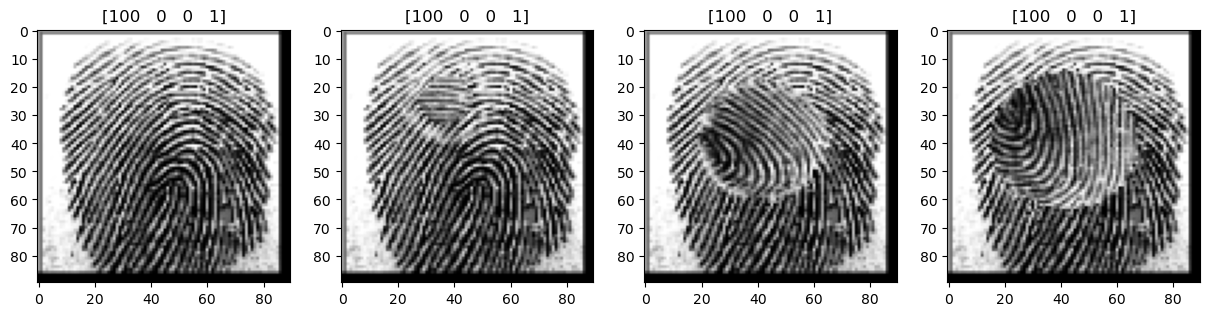

In [63]:
x_real = np.load('dataset/x_real2.npy')
y_real = np.load('dataset/y_real2.npy')
x_easy = np.load('dataset/x_easy2.npy')
y_easy = np.load('dataset/y_easy2.npy')
x_medium = np.load('dataset/x_medium2.npy')
y_medium = np.load('dataset/y_medium2.npy')
x_hard = np.load('dataset/x_hard2.npy')
y_hard = np.load('dataset/y_hard2.npy')

print(x_real.shape, y_real.shape)

plt.figure(figsize=(15, 10))
plt.subplot(1, 4, 1)
plt.title(y_real[0])
plt.imshow(x_real[0].squeeze(), cmap='gray')
plt.subplot(1, 4, 2)
plt.title(y_easy[0])
plt.imshow(x_easy[0].squeeze(), cmap='gray')
plt.subplot(1, 4, 3)
plt.title(y_medium[0])
plt.imshow(x_medium[0].squeeze(), cmap='gray')
plt.subplot(1, 4, 4)
plt.title(y_hard[0])
plt.imshow(x_hard[0].squeeze(), cmap='gray')

print(x_real[0].shape)

# Train Test Split

In [64]:
x_data = np.concatenate([x_easy, x_medium, x_hard], axis=0)
label_data = np.concatenate([y_easy, y_medium, y_hard], axis=0)

x_train, x_val, label_train, label_val = train_test_split(x_data, label_data, test_size=0.2)

print(x_data.shape, label_data.shape)
print(x_train.shape, label_train.shape)
print(x_val.shape, label_val.shape)

(49270, 90, 90) (49270, 4)
(39416, 90, 90) (39416, 4)
(9854, 90, 90) (9854, 4)


# Preview Augmentation

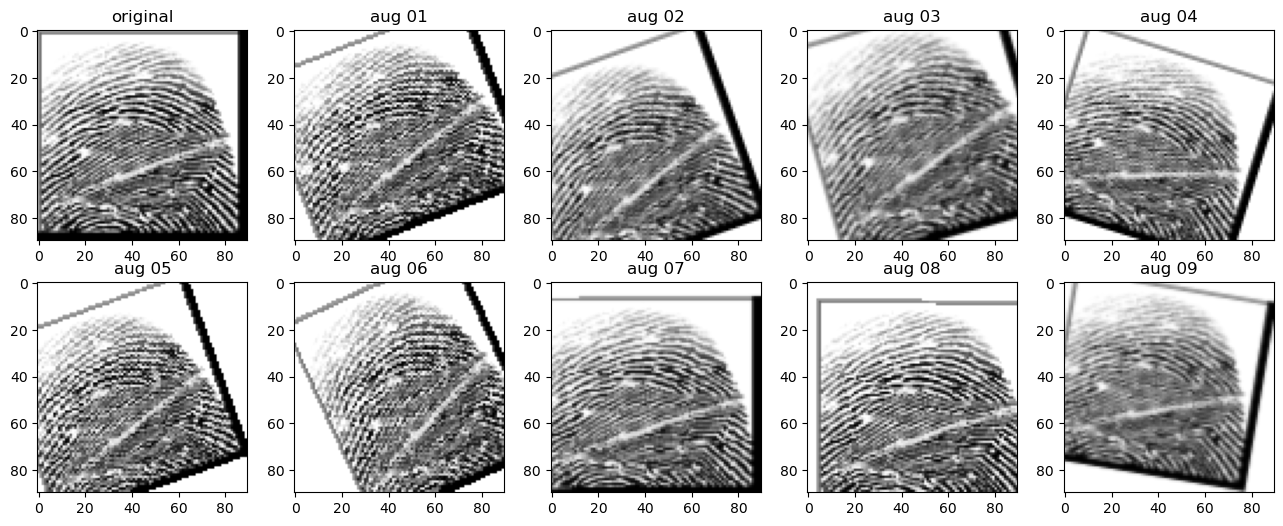

In [65]:
augs = [x_data[40000]] * 9

seq = iaa.Sequential([
    # blur images with a sigma of 0 to 0.5
    iaa.GaussianBlur(sigma=(0, 0.5)),
    iaa.Affine(
        # scale images to 90-110% of their size, individually per axis
        scale={"x": (0.9, 1.1), "y": (0.9, 1.1)},
        # translate by -10 to +10 percent (per axis)
        translate_percent={"x": (-0.1, 0.1), "y": (-0.1, 0.1)},
        # rotate by -30 to +30 degrees
        rotate=(-30, 30),
        # use nearest neighbour or bilinear interpolation (fast)
        order=[0, 1],
        # if mode is constant, use a cval between 0 and 255
        cval=255
    )
], random_order=True)

augs = seq.augment_images(augs)

plt.figure(figsize=(16, 6))
plt.subplot(2, 5, 1)
plt.title('original')
plt.imshow(x_data[40000].squeeze(), cmap='gray')
for i, aug in enumerate(augs):
    plt.subplot(2, 5, i+2)
    plt.title('aug %02d' % int(i+1))
    plt.imshow(aug.squeeze(), cmap='gray')

# Make Label Dictionary Lookup Table

In [66]:
label_real_dict = {}

for i, y in enumerate(y_real):
    key = y.astype(str)
    key = ''.join(key).zfill(6)

    label_real_dict[key] = i

# Data Generator

In [67]:
class DataGenerator(keras.utils.Sequence):
    def __init__(self, x, label, x_real, label_real_dict, batch_size=300, shuffle=True):
        'Initialization'
        self.x = x
        self.label = label
        self.x_real = x_real
        self.label_real_dict = label_real_dict
        
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.x) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        x1_batch = self.x[index*self.batch_size:(index+1)*self.batch_size]
        label_batch = self.label[index*self.batch_size:(index+1)*self.batch_size]
        
        x2_batch = np.empty((self.batch_size, 90, 90), dtype=np.float32)
        y_batch = np.zeros((self.batch_size, 1), dtype=np.float32)
        
        # augmentation
        if self.shuffle:
            seq = iaa.Sequential([
                iaa.Affine(
                    scale={"x": (0.7, 1.3), "y": (0.7, 1.3)},
                    translate_percent={"x": (-0.3, 0.3), "y": (-0.3, 0.3)},
                    rotate=(-30, 30),
                    order=[0, 1],
                    cval=255
                )
            ], random_order=True)

            x1_batch = seq.augment_images(x1_batch)
        
        #pick matched images(label 1.0) and unmatched images(label 0.0) and put together in batch
        #matched images must be all same, [subject_id(3), gender(1), left_right(1), finger(1)], e.g) 034010
        for i, l in enumerate(label_batch):
            match_key = l.astype(str)
            match_key = ''.join(match_key).zfill(6)

            if random.random() > 0.5:
                # put matched image
                x2_batch[i] = self.x_real[self.label_real_dict[match_key]]
                y_batch[i] = 1.
            else:
                # put unmatched image
                while True:
                    unmatch_key, unmatch_idx = random.choice(list(self.label_real_dict.items()))

                    if unmatch_key != match_key:
                        break

                x2_batch[i] = self.x_real[unmatch_idx]
                y_batch[i] = 0.

        return [x1_batch.astype(np.float32) / 255., x2_batch.astype(np.float32) / 255.], y_batch

    def on_epoch_end(self):
        if self.shuffle == True:
            self.x, self.label = shuffle(self.x, self.label)

In [68]:
train_gen = DataGenerator(x_train, label_train, x_real, label_real_dict, shuffle=True)
val_gen = DataGenerator(x_val, label_val, x_real, label_real_dict, shuffle=False)

# Create Model

In [69]:
x1 = layers.Input(shape=(96, 96, 1))
x2 = layers.Input(shape=(96, 96, 1))

# share weights both inputs
inputs = layers.Input(shape=(96, 96, 1))

feature = layers.Conv2D(32, kernel_size=3, padding='same', activation='relu')(inputs)
feature = layers.MaxPooling2D(pool_size=2)(feature)

feature = layers.Conv2D(32, kernel_size=3, padding='same', activation='relu')(feature)
feature = layers.MaxPooling2D(pool_size=2)(feature)

feature_model = Model(inputs=inputs, outputs=feature)

# 2 feature models that sharing weights
x1_net = feature_model(x1)
x2_net = feature_model(x2)

# subtract features
net = layers.Subtract()([x1_net, x2_net])

net = layers.Conv2D(32, kernel_size=3, padding='same', activation='relu')(net)
net = layers.MaxPooling2D(pool_size=2)(net)

net = layers.Flatten()(net)

net = layers.Dense(64, activation='relu')(net)

net = layers.Dense(1, activation='sigmoid')(net)

model = Model(inputs=[x1, x2], outputs=net)

model.compile(loss='binary_crossentropy', optimizer=keras.optimizers.SGD(learning_rate = 0.0007) ,metrics=['accuracy'])

model.summary()

ValueError: Exception encountered when calling layer "max_pooling2d_12" (type MaxPooling2D).

Negative dimension size caused by subtracting 2 from 1 for '{{node max_pooling2d_12/MaxPool}} = MaxPool[T=DT_FLOAT, data_format="NHWC", explicit_paddings=[], ksize=[1, 2, 2, 1], padding="VALID", strides=[1, 2, 2, 1]](Placeholder)' with input shapes: [?,1,90,32].

Call arguments received by layer "max_pooling2d_12" (type MaxPooling2D):
  • inputs=tf.Tensor(shape=(None, 1, 90, 32), dtype=float32)

# Train

In [ ]:
MODEL_SAVE_FOLDER_PATH = 'model/'
if not os.path.exists(MODEL_SAVE_FOLDER_PATH):
    os.mkdir(MODEL_SAVE_FOLDER_PATH)

model_path = MODEL_SAVE_FOLDER_PATH + '1014.h5'

cb_checkpoint = ModelCheckpoint(filepath=model_path, monitor='val_accuracy',
                                verbose=1, save_best_only=True)

history = model.fit_generator(train_gen, epochs=30,callbacks=[cb_checkpoint], validation_data=val_gen)


/var/folders/75/jthgt21s2jn6xcmykzlz07j40000gn/T/ipykernel_76850/2806121706.py:10: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_gen, epochs=30,callbacks=[cb_checkpoint], validation_data=val_gen)


ValueError: could not broadcast input array from shape (90,90) into shape (90,90,1)

In [ ]:
print(history.history.keys())

# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Evaluation

In [ ]:
# new user fingerprint input
from keras.models import load_model
import glob
import cv2
from PIL import Image
import time

start_time = time.time()

model_list = glob.glob('model/*.h5')
model_name = model_list[-1]

best_model = load_model(model_name)

img1_name = 'test_data/'
img2_name = 'test_data/'

input_img1 = cv2.imread(img1_name ,cv2.IMREAD_GRAYSCALE)
input_img2 = cv2.imread(img2_name, cv2.IMREAD_GRAYSCALE)


input_img11 = cv2.resize(input_img1, (90, 90)).reshape((1, 90, 90, 1)).astype(np.float32) /255
input_img22 = cv2.resize(input_img2, (90, 90)).reshape((1, 90, 90, 1)).astype(np.float32) / 255.

input_data = []
input_data.append(input_img11)
input_data.append(input_img22)
input_data = np.array(input_data)

pred_rx = best_model.predict((input_data[0], input_data[1]))

if pred_rx > 0.5:
    print('score={} : matched'.format(pred_rx))
    fig, axes = plt.subplots(1,2,figsize = (12,12))
    axes[0].set_title("input1")
    axes[0].imshow(input_img1)
    axes[1].set_title("input2")
    axes[1].imshow(input_img2)
    print('WorkingTime: {}sec'.format(time.time()-start_time))

else:
    print('score={} : unmatched'.format(pred_rx))
    fig, axes = plt.subplots(1,2,figsize = (12,12))
    axes[0].set_title("input1")
    axes[0].imshow(input_img1)
    axes[1].set_title("input2")
    axes[1].imshow(input_img2)
    print('WorkingTime: {}sec'.format(time.time()-start_time))

In [ ]:
# new user fingerprint input
from keras.models import load_model
import cv2

model = load_model('/Users/qsiik/Desktop/fingerprint_from_image/model/0629.h5')

random_idx = random.randint(0, len(x_val))

random_img = x_val[random_idx]
random_label = label_val[random_idx]

seq = iaa.Sequential([
    iaa.GaussianBlur(sigma=(0, 0.5)),
    iaa.Affine(
        scale={"x": (0.9, 1.1), "y": (0.9, 1.1)},
        translate_percent={"x": (-0.1, 0.1), "y": (-0.1, 0.1)},
        rotate=(-30, 30),
        order=[0, 1],
        cval=255
    )
], random_order=True)

random_img = seq.augment_image(random_img).reshape((1, 90, 90, 1)).astype(np.float32) / 255.

# matched image
match_key = random_label.astype(str)
match_key = ''.join(match_key).zfill(6)

rx = x_real[label_real_dict[match_key]].reshape((1, 90, 90, 1)).astype(np.float32) / 255.
ry = y_real[label_real_dict[match_key]]

pred_rx = model.predict([random_img, rx])

# unmatched image
unmatch_key, unmatch_idx = random.choice(list(label_real_dict.items()))

ux = x_real[unmatch_idx].reshape((1, 90, 90, 1)).astype(np.float32) / 255.
uy = y_real[unmatch_idx]

pred_ux = model.predict([random_img, ux])

plt.figure(figsize=(8, 4))
plt.subplot(1, 3, 1)
plt.title('Input: %s' %random_label)
plt.imshow(random_img.squeeze(), cmap='gray')
plt.subplot(1, 3, 2)
plt.title('O: %.02f, %s' % (pred_rx, ry))
plt.imshow(rx.squeeze(), cmap='gray')
plt.subplot(1, 3, 3)
plt.title('X: %.02f, %s' % (pred_ux, uy))
plt.imshow(ux.squeeze(), cmap='gray')